<font size=6px><center><b>Real or Not? NLP with Disaster Tweets</b></center></font>
<br>
<font size=4px><center><b>Part 2</b></center></font>
<br>
<font size=2px><center><b>Ignat Baltsyukevich(IgnatBaltsyukevich@coherentsolutions.com)</b></center></font>

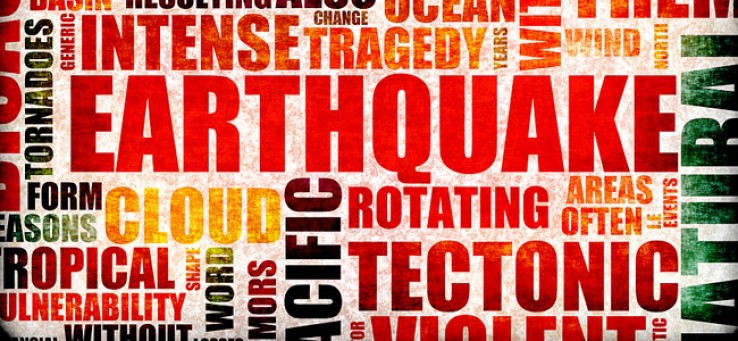

<font size=4px><b>Link to kaggle competition: [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started)</b></font>
<br>
<br>
<font size=4px><b>[Link to data](https://drive.google.com/drive/folders/1ZLlAlTKBkIrSMetqX4AoLADEEMulnY43?usp=sharing)</b></font>

# ML Pipeline

* ## **[Business domain](#Business-domain)**
*   [Define business goals and objectives](#Define-business-goals-and-objectives)
*   [Determine the problems to solve](#Determine-the-problems-to-solve)

* ## **[Data analysis](#Introduction)**
*   [Extract, transform and load data](#Extract,-transform-and-load-data)
*   [Exploratory data analysis](#Exploratory-data-analysis)
*   [Prepare data according to the ML algorithm](#Prepare-data-according-to-the-ML-algorithm)

* ## **[Frameworks and Modelling](#Frameworks-and-Modelling)**
*   [Train ML model and validate obtained results](#Train-ML-model-and-validate-obtained-results)
*   [Tune parameters of the model for better results](#Tune-parameters-of-the-model-for-better-results)

* ## **<font color='grey'>Hosting and Delivery</font>**

*   <font color='grey'>Deploy model into production environment</font>
*   <font color='grey'>Monitor and improve deployed model</font>

* ## **[Conclusion](#Conclusion)**
*   [Usefull links](#Usefull-links)

# Business domain

## Define business goals and objectives

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

### **Goal:**
* Improve our baseline model

### **Objectives:**
*  Vectorizing tweets
*  Encoding features location and keywords
*  Feature engineering
*  Feature selection
*  Tuning hyperparameters

## Determine the problems to solve

### **Specified approaches to solve the problems:**

* Word embedding trained on lstm
* Target encoder
* RFECV, GenericUnivariateSelect
* Grid Search

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
import re
import string

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from category_encoders.target_encoder import TargetEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import codecs
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, LSTM, Bidirectional
from keras import backend as K

from sklearn.feature_selection import RFECV, GenericUnivariateSelect, chi2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Extract, transform and load data

In [ ]:
#Путь к данным
#ВАЖНО! При локальной работе с данными поменяйте это на местоположение данных на вашей машине.
# Найти их можно <dataset/ML_Weekly/7/NLP_tweets.zip>
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Prepare data according to the ML algorithm

In [ ]:
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove links
    text = re.sub(r'<.*?>', '', text) # Remove html tags 
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # Remove emoji
    
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if word.isalpha()]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return text

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
train['text_clean'] = train['text'].apply(clean_text)
test['text_clean'] = test['text'].apply(clean_text)

## Word embedding

Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.

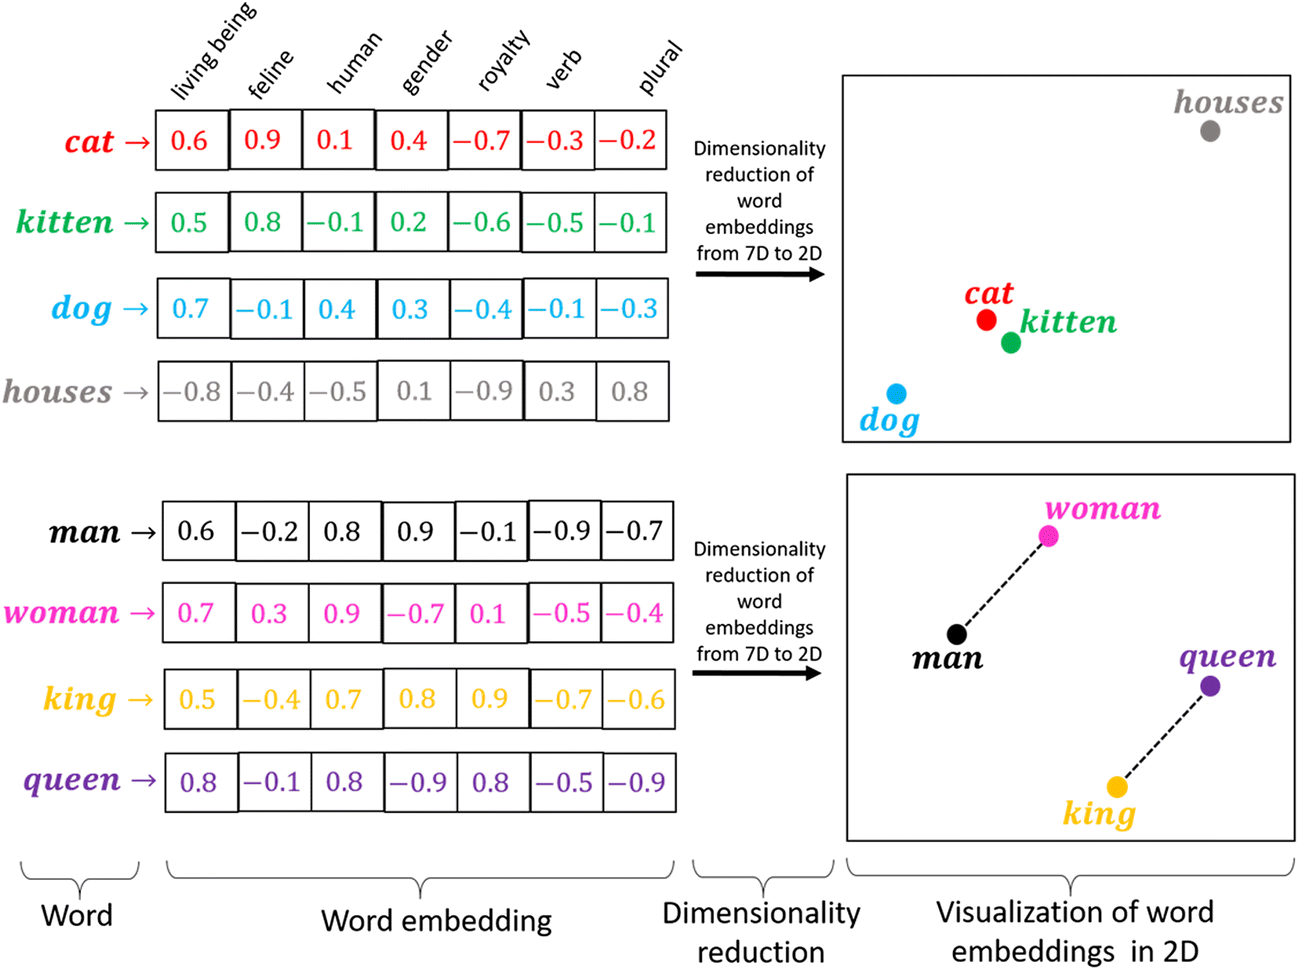

0_C3EJEPTHttzSO3AE.png


1_BYzzejeXxAIX27ShVQQp8w.png

- Load text data in array.
- Process the data.
- Convert the text to sequence and using the tokenizer and pad them with keras.preprocessing.text.pad_sequences method.
- Initialise a model with Embedding layer of dimensions (max_words, representation_dimensions, input_size))
    * max_words: It is the no. of unique words in your data
    * representation_dimension: It is the no. of dimensions in which you want to represent a word. Usually, it is number of (unique words)^(1/4)
    * input_size: size of your padded sequence(maxlen)
- Run the model

We will use pre-trained word vectors 'wiki-news-300d-1M.vec', which contains 1 million words trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset

In [ ]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

887it [00:00, 8801.83it/s]

loading word embeddings...


999995it [01:28, 11239.76it/s]

found 999995 word vectors


In [ ]:
# parameters for model
num_epochs = 15
MAX_NB_WORDS = 100000
maxlen = 21
embed_dim = 300 

In [ ]:
def convert_data_to_padded_sequence(train, test, maxlen=maxlen, num_words=MAX_NB_WORDS):
    print("Converting data to Sequences")
    # num_words: Top No. of words to be tokenized. Rest will be marked as unknown or ignored.
    tokenizer = Tokenizer(num_words=num_words)
        
    # tokenizing based on "texts". This step generates the word_index and map each word to an integer other than 0.
    data = pd.concat([train, test], ignore_index=True)
    tokenizer.fit_on_texts(data)
        
    # generating sequence based on tokenizer's word_index. Each sentence will now be represented by combination of numericals
    # Example: "Good movie" may be represented by [22, 37]
    seq_train = tokenizer.texts_to_sequences(train)
    seq_test = tokenizer.texts_to_sequences(test)
        
    word_index = tokenizer.word_index
    # padding each numerical representation of sentence to have fixed length.

    print("Data converted to Sequences...")
    return np.array(pad_sequences(seq_train, maxlen=maxlen)), np.array(pad_sequences(seq_test, maxlen=maxlen)), word_index

In [ ]:
def prepare_embedding_matrix(word_index):
    print('preparing embedding matrix...')

    words_not_found = []
    nb_words = min(MAX_NB_WORDS, len(word_index)+1)
    embedding_matrix = np.zeros((nb_words, embed_dim))

    for word, i in word_index.items():
        if i >= nb_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append(word)
    print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix, nb_words, words_not_found

In [ ]:
train_padded, test_padded, word_index = convert_data_to_padded_sequence(train['text_clean'], test['text_clean'])
train_padded

Converting data to Sequences
Data converted to Sequences...


array([[   0,    0,    0, ...,   89, 1546, 2022],
       [   0,    0,    0, ..., 6481, 6482, 1144],
       [   0,    0,    0, ...,  390,  290,  512],
       ...,
       [   0,    0,    0, ...,    0,  381, 1263],
       [   0,    0,    0, ..., 1047, 1182,   94],
       [   0,    0,    0, ...,   92,  522,   10]])

In [ ]:
len(word_index)

16220

In [ ]:
embedding_matrix, nb_words, words_not_found = prepare_embedding_matrix(word_index)

preparing embedding matrix...
number of null word embeddings: 5346


In [ ]:
"sample words not found: ", np.random.choice(words_not_found, 10)

('sample words not found: ',
 array(['newscomauhq', 'handmadejewelry', 'nuclearrcsa', 'stormchase',
        'solano', 'shizune', 'atlwtmgc', 'windowgatribble', 'gnwt',
        'snazzychipz'], dtype='<U31'))

## Long short-term memory (LSTM) neural networks

LSTM networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

In [ ]:
def init_model(num_words, embedding_matrix, maxlen=maxlen):
    
        model = Sequential()
        model.add(Embedding(num_words, embed_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
        model.add(Dropout(0.3))
        model.add(Dense(32,activation='relu'))
        model.add(Bidirectional(LSTM(64,return_sequences= True)))
        model.add(Bidirectional(LSTM(64,return_sequences= True)))
        model.add(Bidirectional(LSTM(64,return_sequences= True)))
        model.add(Bidirectional(LSTM(64,return_sequences= True)))
        model.add(Bidirectional(LSTM(32)))
        model.add(Dense(32,activation='relu'))
        model.add(Dropout(0.3))

        model.add(Dense(1,activation='sigmoid'))

        print(model.summary())
        return model

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def run_the_model(model, X, y, optimizer = 'rmsprop', epochs = num_epochs, validation_split=0.2):
        
        model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=[f1_m])
        return model.fit(X, y, epochs=epochs, validation_split=validation_split)

In [ ]:
def plot_model_output(history, epochs=num_epochs):
        plt.figure()
        plt.plot(range(1, epochs + 1), history.history['loss'][:epochs],label = 'training_loss')
        plt.plot(range(1, epochs + 1), history.history['val_loss'][:epochs],label = 'validation_loss')
        plt.legend()
        plt.figure()
        plt.plot(range(1, epochs + 1), history.history['f1_m'][:epochs],label = 'training_f1')
        plt.plot(range(1, epochs + 1), history.history['val_f1_m'][:epochs],label = 'validation_f1')
        plt.legend()
        plt.show()

In [ ]:
model = init_model(nb_words, embedding_matrix)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 300)           4866300   
_________________________________________________________________
dropout (Dropout)            (None, 21, 300)           0         
_________________________________________________________________
dense (Dense)                (None, 21, 32)            9632      
_________________________________________________________________
bidirectional (Bidirectional (None, 21, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 21, 128)           9

In [ ]:
np.random.seed(41)
y_train = train['target']
history = run_the_model(model, train_padded, y_train, epochs=30)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

In [ ]:
plot_model_output(history, 30)

In [ ]:
lstm_model = init_model(nb_words, embedding_matrix)
run_the_model(lstm_model, train_padded, y_train, epochs = 15, validation_split=None)

In [ ]:
train_embedding = pd.DataFrame({'word_embedding_predictions':lstm_model.predict(train_padded).flatten()})
# train_embedding.to_csv('be st_embedding_train.csv',index=False)

In [ ]:
train_embedding.sample(3)

word_embedding_predictions
6887                    0.241725
3312                    0.999409
4687                    0.511736

In [ ]:
test_embedding = pd.DataFrame({'word_embedding_predictions':lstm_model.predict(test_padded).flatten()})
# test_embedding.to_csv('best_embedding_test.csv',index=False)

## Encoding keywords and locations

In [ ]:
train_embedding = pd.read_csv("best_embedding_train.csv")
test_embedding = pd.read_csv("best_embedding_test.csv")

In [ ]:
train['keyword'].fillna('Unknown', inplace=True)
test['keyword'].fillna('Unknown', inplace=True)

train['location'].fillna('Unknown', inplace=True)
test['location'].fillna('Unknown', inplace=True)

In [ ]:
print(train.keyword.nunique(), test.keyword.nunique())
set(train.keyword.unique()) - set(test.keyword.unique())

222 222


set()

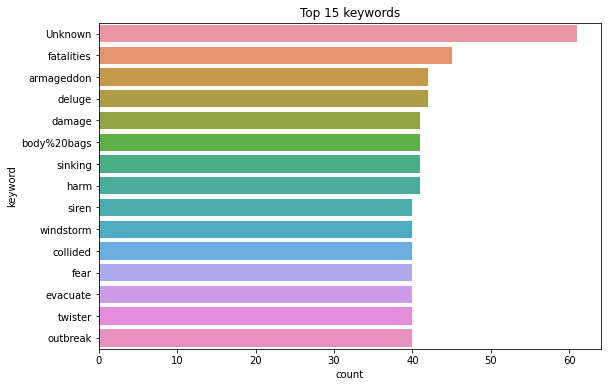

In [ ]:
# Most common keywords
plt.figure(figsize=(9,6))
sns.countplot(y=train['keyword'], order = train['keyword'].value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

In [ ]:
kw_d = train[train['target']==1]['keyword'].value_counts().head(10)
kw_nd = train[train['target']==0]['keyword'].value_counts().head(10)

plt.figure(figsize=(17,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='r')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='g')
plt.title('Top keywords for non-disaster tweets')
plt.show()

In [ ]:
top_d = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(18,5))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='r')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='g')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

In [ ]:
train.location.nunique(), test.location.nunique()

(3341, 1603)

In [ ]:
len(set(train.location.unique()) - set(test.location.unique()))

2918

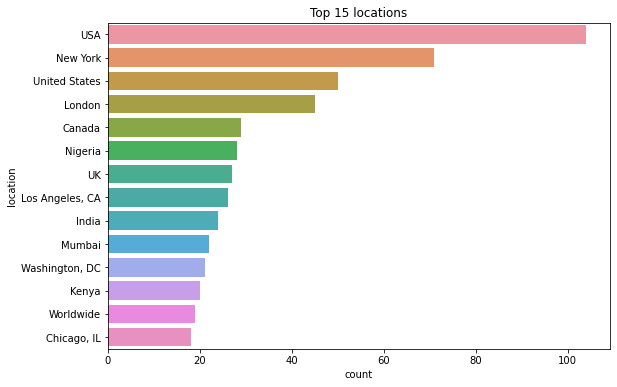

In [ ]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train['location'], order = train['location'].value_counts().iloc[1:15].index)
plt.title('Top 15 locations')
plt.show()

In [ ]:
raw_loc = train['location'].value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train['location'].isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

In [ ]:
train.loc[train['location'] == 'Mumbai', 'location'] = 'India'
train.loc[(train['location'] == 'Earth') | (train['location'] == 'Everywhere'), 'location'] = 'Worldwide'
train.loc[train['location'] == 'Washington, DC', 'location'] = 'Washington, D.C.'
train.loc[train['location'] == 'United States', 'location'] = 'USA'
train.loc[train['location'] == 'United Kingdom', 'location'] = 'UK'
train.loc[(train['location'] == 'London, England') | (train['location'] == 'London, UK'), 'location'] = 'London'
train.loc[train['location'] == 'San Francisco, CA', 'location'] = 'San Francisco'
train.loc[(train['location'] == 'New York City') | (train['location'] == 'New York, NY') | (train['location'] == 'NYC'), 'location'] = 'New York'
train.loc[train['location'] == 'Los Angeles, CA', 'location'] = 'Los Angeles'
train.loc[train['location'] == 'Chicago, IL', 'location'] = 'Chicago'
train.loc[train['location'] == 'California, USA', 'location'] = 'California'

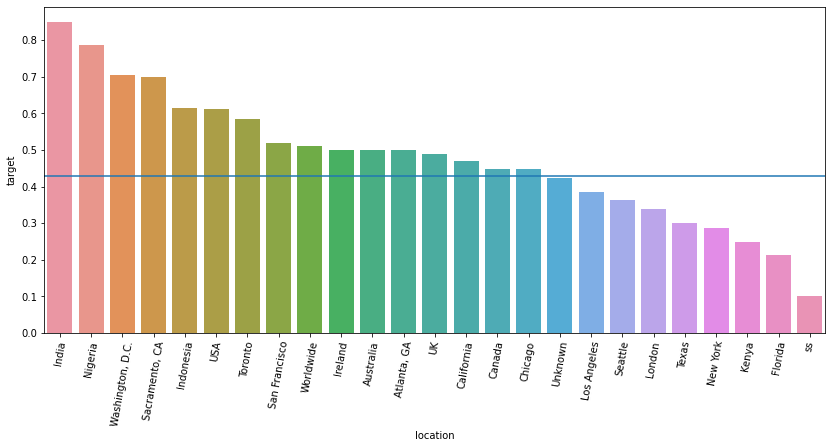

In [ ]:
raw_loc = train['location'].value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train['location'].isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

In [ ]:
# Target encoding
features = ['keyword', 'location']
encoder = TargetEncoder(cols=features)
encoder.fit(train[features], train['target'])

X_train_ce = train_embedding.join(encoder.transform(train[features]).add_suffix('_target'))
X_test_ce = test_embedding.join(encoder.transform(test[features]).add_suffix('_target'))

In [ ]:
X_train_ce.sample(2)

word_embedding_predictions  keyword_target  location_target
1226                    0.619023        0.685714         0.424458
265                     0.142066        0.344828         0.481083

## Feature engineering

In [ ]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

In [ ]:
def create_stat(df):
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # Tweet length
    df['text_len'] = df['text'].apply(len)
    # Word count  
    df['word_count'] = df["text"].str.split().apply(lambda x : len(x))
    # Unique word count
    df['unique_word_count'] = df["text"].str.split().apply(lambda x : len(set(x)))
    # Stopword count
    df['stop_words_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
    # Punctuation count
    df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    # Ratio of uppercase letters
    df['mean_len_words'] = df['text'].str.split().apply(lambda x: np.mean([len(w) for w in x]))
    # Hashtag presence
    df['contains_hashtags'] = df['text'].str.findall(r'#(\w+)').apply(lambda x : 0 if len(x) == 0 else 1)
    # User's mention presence
    df['contains_user_mention'] = df['text'].str.findall(r'@(\w+)').apply(lambda x : 0 if len(x) == 0 else 1)
    # Punctuations presence
    df['contains_punctuation'] = df['text'].str.replace(r'[\w\s#]+', '').apply(lambda x : 0 if len(x) == 0 else 1)
    # Urls presence
    df['contains_urls'] = df['text'].str.findall(r'https?://\S+|www\.\S+').apply(lambda x : len(x))
    # Is it reply
    df['is_reply'] = df['text'].str.startswith('RT')
    return df

In [ ]:
X_train_all = X_train_ce.join(create_stat(train))
X_test_all = X_test_ce.join(create_stat(test))

X_train_all.shape, X_test_all.shape

((7613, 28), (3263, 27))

In [ ]:
X_train_all.drop(columns = ['target', 'id', 'keyword', 'location', 'text', 'text_clean', 'hashtags', 'mentions', 'links'], inplace=True)
X_test_all.drop(columns = ['id', 'keyword', 'location', 'text', 'text_clean', 'hashtags', 'mentions', 'links'], inplace=True)

In [ ]:
X_train_all.sample(3)

word_embedding_predictions  keyword_target  location_target  text_len  \
3036                    0.959966        0.769231         0.481083       140   
3631                    0.137669        0.577778         0.424458       106   
592                     0.662323        0.594595         0.666587        98   

      word_count  unique_word_count  stop_words_count  punctuation_count  \
3036          18                 14                 4                 13   
3631          19                 19                 9                  4   
592           14                 14                 4                  5   

      hashtag_count  mention_count  link_count  caps_count  caps_ratio  \
3036              2              1           1          70    0.500000   
3631              1              1           1           9    0.084906   
592               1              1           1           7    0.071429   

      mean_len_words  contains_hashtags  contains_user_mention  \
3036        6.777778                  1                      0   
3631        4.631579                  0                      0   
592         6.071429                  0                      0   

      contains_punctuation  contains_urls  is_reply  
3036                     1              1     False  
3631                     1              0     False  
592                      1              1     False

In [ ]:
scaler = MinMaxScaler()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=995)

In [ ]:
scaler = MinMaxScaler()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=995)

svc = LinearSVC(random_state=12)
lr = LogisticRegression(random_state=12)
nb = MultinomialNB()
ridge = RidgeClassifier(random_state=12)
models = [svc, lr, nb, ridge]
for model in models:
    print(model)
    pipeline = Pipeline([('scale',scaler), ('classifier', model),])
    cv_score = cross_val_score(pipeline, X_train_all, y_train, cv=cv, scoring='f1')
    print('Cross validation F-1 score: %.3f' %np.mean(cv_score))
    print()

LinearSVC(random_state=12)
Cross validation F-1 score: 0.818

LogisticRegression(random_state=12)
Cross validation F-1 score: 0.822

MultinomialNB()
Cross validation F-1 score: 0.780

RidgeClassifier(random_state=12)
Cross validation F-1 score: 0.813



In [ ]:
catboost = CatBoostClassifier(random_state=34, verbose=0)
cv_score = cross_val_score(catboost, X_train_all, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score:', np.mean(cv_score))

Cross validation F-1 score: 0.8198682304702066


In [ ]:
xgboost = XGBClassifier(random_state=53)
cv_score = cross_val_score(xgboost, X_train_all, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score:', np.mean(cv_score))

Cross validation F-1 score: 0.8014455176920698


| Model | F1_score |
| --- | --- | 
| LogisticRegression | 0.822 |
| CatBoostClassifier | 0.820 |
| LinearSVC | 0.818 |
| RidgeClassifier | 0.813 |
| XGBClassifier | 0.801 |
| MultinomialNB | 0.780 |

In [ ]:
# best alorithm
pipeline = Pipeline([('scale',scaler), ('classifier', lr)])
cv_score = cross_val_score(pipeline, X_train_all, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.4f' %np.mean(cv_score))
pipeline.fit(X_train_all, y_train)

Cross validation F-1 score: 0.8220


Pipeline(steps=[('scale', MinMaxScaler()),
                ('classifier', LogisticRegression(random_state=12))])

## Feature Selection

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

How to select features and what are Benefits of performing feature selection before modeling your data?
* Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
* Improves Accuracy: Less misleading data means modeling accuracy improves.
* Reduces Training Time: fewer data points reduce algorithm complexity and algorithms train faster.

In [ ]:
# defining feature importance
plt.figure(figsize=(20,7))
s1 = pd.Series(np.transpose(pipeline['classifier'].coef_[0]), index=X_train_all.columns).sort_values(ascending=False)[:20]
s2 = pd.Series(np.transpose(pipeline['classifier'].coef_[0]), index=X_train_all.columns).sort_values()[:20]
plt.subplot(121)
sns.barplot(y=s1.index, x=s1)
plt.title('Feature importance');

Recursive Feature Elimination, or RFE for short, works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

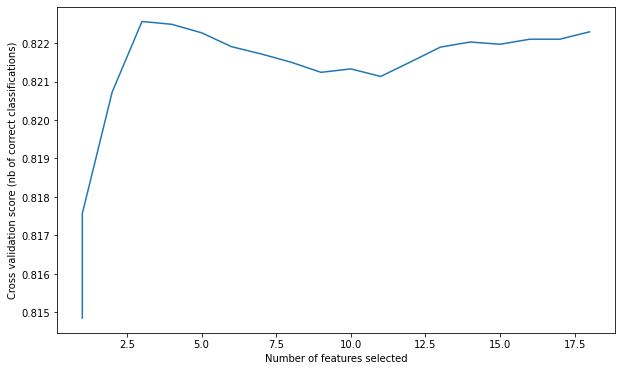

In [ ]:
n_features = len(X_train_all.columns)
X_range = np.arange(1, n_features)

rfecv = RFECV(estimator=lr, step=1, cv=cv, scoring='f1')

pipeline = Pipeline([('scale',scaler), ('rfecv', rfecv)])
pipeline.fit(X_train_all, y_train)
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(np.insert(X_range, 0, 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.grid_scores_

array([0.81485607, 0.81756961, 0.82072484, 0.8225604 , 0.82248641,
       0.82226521, 0.82190539, 0.82171507, 0.8215009 , 0.82123857,
       0.82132813, 0.82113129, 0.82150981, 0.82189398, 0.82202639,
       0.82196855, 0.8220994 , 0.8220994 , 0.82229187])

In [ ]:
print ('Optimal no. of features: %d' % np.insert(X_range, 0, 1)[np.argmax(rfecv.grid_scores_) + 1])

Optimal no. of features: 4


In [ ]:
X_train_all.columns[rfecv.ranking_ == 1]

Index(['word_embedding_predictions', 'keyword_target', 'location_target',
       'mean_len_words'],
      dtype='object')

In [ ]:
selected_features = X_train_all.columns[rfecv.ranking_ == 1]
X_train_cropped = X_train_all[selected_features]
X_test_cropped = X_test_all[selected_features]

In [ ]:
pipeline = Pipeline([('scale',scaler), ('classifier', lr)])
cv_score = cross_val_score(pipeline, X_train_cropped, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.4f' %np.mean(cv_score))

Cross validation F-1 score: 0.8226


GenericUnivariateSelect is a sklearn.feature_selection tool that allows you to select features from a dataset using a scoring function.

In [ ]:
n_features = len(X_train_all.columns)
X_range = np.arange(1, n_features)
scaler = MinMaxScaler()
pipeline = Pipeline([('scale',scaler), ('lr', lr)])
results = []
for number_of_features in X_range:
    transformer = GenericUnivariateSelect(chi2, mode='k_best', param=number_of_features)
    X_new = transformer.fit_transform(X_train_all, y_train)
    cv_score = cross_val_score(pipeline, X_new, y_train, cv=cv, scoring='f1')
    results.append(np.mean(cv_score))

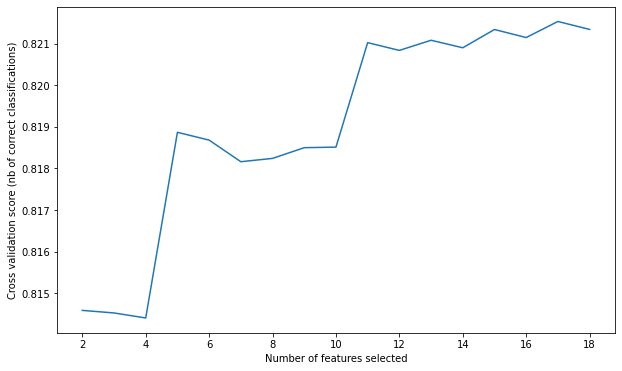

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(X_range[1:], results[1:])
plt.show()

In [ ]:
transformer = GenericUnivariateSelect(chi2, mode='k_best', param=17)
X_new = transformer.fit_transform(X_train_all, y_train)
np.mean(cross_val_score(pipeline, X_new, y_train, cv=cv, scoring='f1'))

0.8215289970382283

In [ ]:
cols = transformer.get_support(indices=True)

In [ ]:
set(X_train_all.columns) - set(X_train_all.iloc[:,cols].columns)

{'caps_ratio', 'link_count'}

## Hyperparameter Tuning

In [ ]:
grid={"C":np.logspace(-5,5,20), "solver":['lbfgs', 'liblinear', 'sag', 'saga']}
lr_cv = GridSearchCV(LogisticRegression(solver='liblinear', random_state=20), grid, cv=cv, scoring = 'f1')

pipeline_grid = Pipeline([('scale',scaler), ('gridsearch', lr_cv)])

pipeline_grid.fit(X_train_cropped, y_train);

In [ ]:
print("Best parameter: ", lr_cv.best_params_)
print("F-1 score: %.4f" %lr_cv.best_score_)

Best parameter:  {'C': 1.8329807108324339, 'solver': 'sag'}
F-1 score: 0.8232


# Conclusion

| Model | F1_score on validation dataset| F1_score on test dataset|
| --- | --- |  --- | 
| Baseline model: Tf-IDF with Ridge Classifier| 0.755 | 0.563
| Final model: Word Embedding predictions and new features with feature selection| 0.823 | 0.808

In the 2 part of meetup we improved our baseline model (TF-IDF with Ridge Classifier) by 43.5% on test dataset. For this we use word embeddings with lstm, target encoding, feature engineering, feature selection and hyperparameters tuning. 

## Usefull links

[**Word Embeddings**](https://habr.com/ru/company/ods/blog/329410/)
<br>
[**LSTM**](https://habr.com/ru/company/wunderfund/blog/331310/)
<br>
[**Feature selection**](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)
<br>
[**Recursive Feature Elimination (RFE)**](https://machinelearningmastery.com/rfe-feature-selection-in-python/)